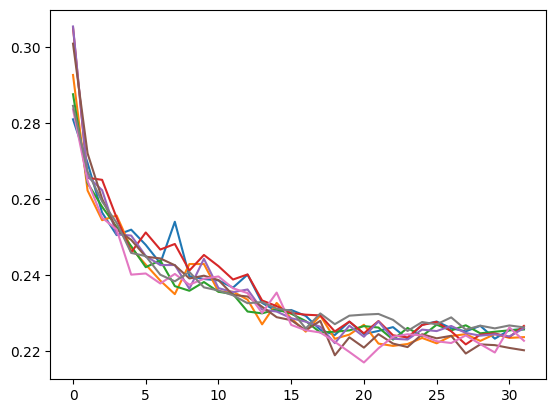

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"fold-{fold}/history.csv")
    
    plt.plot(df.epoch, df.valid_loss, label='valid_loss')


max_acc: 0.9134758710861206


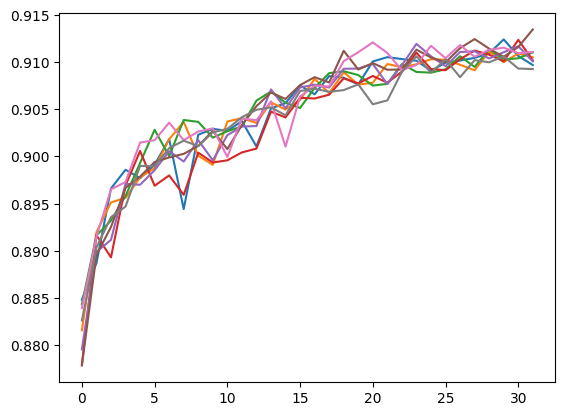

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


max_acc = 0.0
# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"fold-{fold}/history.csv")
    
    plt.plot(df.epoch, df.multi_label_accuracy, label='multi_label_accuracy')

    if np.max(df.multi_label_accuracy) > max_acc:
        max_acc = np.max(df.multi_label_accuracy)

print(f"max_acc: {max_acc}")

min_hamming: 0.0865242817187897


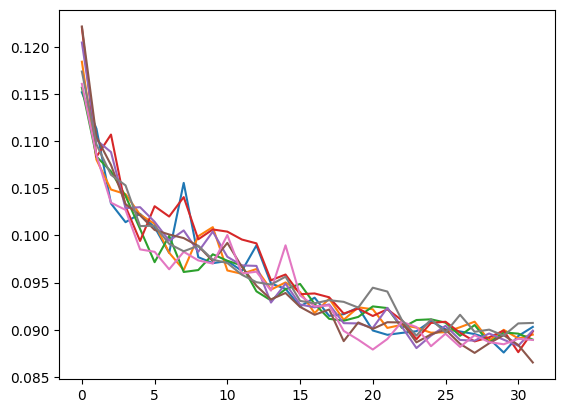

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


min_hamming = 1.0
# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"fold-{fold}/history.csv")
    
    plt.plot(df.epoch, df.multilabel_hamming_loss, label='multilabel_hamming_loss')

    if np.min(df.multilabel_hamming_loss) < min_hamming:
        min_hamming = np.min(df.multilabel_hamming_loss)

print(f"min_hamming: {min_hamming}")

max_f1_score: 0.6443705030902074


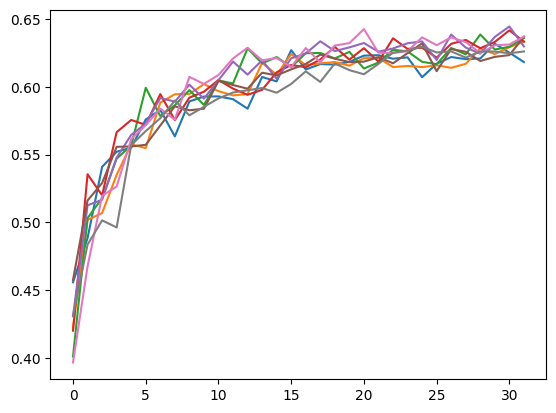

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


max_f1_score = 0.0
# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"fold-{fold}/history.csv")
    
    plt.plot(df.epoch, df.macro_f1_score_multilabel, label='macro_f1_score_multilabel')

    if np.max(df.macro_f1_score_multilabel) > max_f1_score:
        max_f1_score = np.max(df.macro_f1_score_multilabel)

print(f"max_f1_score: {max_f1_score}")

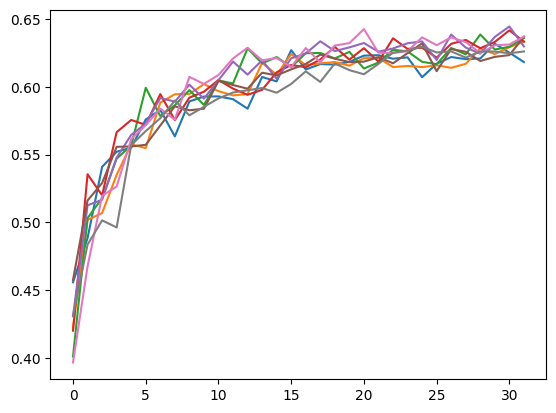

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"fold-{fold}/history.csv")
    
    plt.plot(df.epoch, df.macro_f1_score_multilabel, label='macro_f1_score_multilabel')


In [6]:
import sys
sys.path.append('../../src')
sys.path.append('../../')
import json



config_file_path = "config.json"
with open(config_file_path, "r") as f:
    config_data = json.load(f)

config_data

{'OUT': 'experiments/baseline-plus-augms-manyfolds/',
 'PATH': 'data/data_dumps/sr100/',
 'TEST_FOLDS': [9, 10],
 'NUM_WORKERS_DATALOADER': 4,
 'SEED': 42,
 'BATCH_SIZE': 32,
 'BATCH_SIZE_EFFECTIVE': 32,
 'LMAX': 192,
 'LMAX_VALIDATION': 768,
 'EPOCHS': 32,
 'LR_MAX': 0.0003,
 'MODEL': 'DeepHeartModel',
 'DIV': 25,
 'DIV_FINAL': 25,
 'MOMS': [0.95, 0.95, 0.95],
 'EMA': False,
 'MODEL_KWARGS': {'dim': 192,
  'dim_base': 128,
  'depth': 12,
  'head_size': 16,
  'drop_path': 0.2},
 'WEIGHTS': False,
 'LOSS_FUNC': 'binary_cross_entropy',
 'METRICS': ['multi_label_accuracy',
  'multilabel_hamming_loss',
  'macro_f1_score_multilabel']}

In [7]:
from models import DeepHeartModel
model = DeepHeartModel(**config_data["MODEL_KWARGS"]);

In [8]:
import torch
from dataloaders import ECGDataset

models = {}

ds_val = ECGDataset(
    path="/home/viktor/Documents/idoven/idoven-challenge/data/data_dumps/sr100",
    mode="val",
    L=config_data["LMAX_VALIDATION"],
    test_folds=[9],
)


for fold in range(1, 9):
    
    print(f"Loading model for fold {fold} ... ")
    loaded_weights = torch.load(f"fold-{fold}/models/model_31.pth")
    _model = DeepHeartModel(**config_data["MODEL_KWARGS"])
    _model.load_state_dict(loaded_weights, strict=True)
    _model = _model.cuda()
    models[fold] = _model
    
    
    
    
    

[INFO] Loading data...
Loading model for fold 1 ... 
Loading model for fold 2 ... 
Loading model for fold 3 ... 
Loading model for fold 4 ... 
Loading model for fold 5 ... 
Loading model for fold 6 ... 
Loading model for fold 7 ... 
Loading model for fold 8 ... 


In [9]:
len(ds_val)

2183

In [11]:
from tqdm import tqdm

# loop through ds_val

y_true_batch = []
y_pred_batch = []
model_preds = {}

for fold in range(1, 9):
    model_preds[fold] = []

for out in tqdm(ds_val, total=len(ds_val)):
    
    x, y = out[0], out[1]
    
    # send to device
    x['x'] = torch.unsqueeze(x['x'], 0).cuda()
    y['y'] = torch.unsqueeze(y['y'], 0).cuda()
    
    
    y_pred = []
    # get the model predictions
    for fold in range(1, 9):
        pred = torch.sigmoid(models[fold](x))
        y_pred.append(pred)
        model_preds[fold].append(pred.cpu().detach().squeeze().numpy())
        
        
    
    # average the predictions
    y_pred = torch.stack(y_pred).mean(dim=0)
    
    # convert to numpy
    y_pred_np = y_pred.cpu().detach().squeeze().numpy()
    
    # get y_true_np
    y_true_np = y['y'].cpu().detach().squeeze().numpy().astype(int)
    
    # append to batch
    y_true_batch.append(y_true_np)
    y_pred_batch.append(y_pred_np)
    

  0%|          | 0/2183 [00:00<?, ?it/s]

100%|██████████| 2183/2183 [00:49<00:00, 44.44it/s]


In [12]:
y_true_batch_torch = {'y': torch.tensor(y_true_batch)}
y_pred_batch_torch = torch.tensor(y_pred_batch)

for fold in range(1, 9):
    model_preds[fold] = torch.tensor(model_preds[fold])

/tmp/ipykernel_870685/3120016003.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/torch/csrc/utils/tensor_new.cpp:245.)
  y_true_batch_torch = {'y': torch.tensor(y_true_batch)}


In [25]:
model_preds[1].shape, y_pred_batch_torch.shape

(torch.Size([2183, 6]), torch.Size([2183, 6]))

In [13]:
from metrics import multi_label_accuracy, multilabel_hamming_loss, macro_f1_score_multilabel

acc = multi_label_accuracy(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)
hamming_loss = multilabel_hamming_loss(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)
f1_score = macro_f1_score_multilabel(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)


acc, hamming_loss, f1_score

(tensor(0.9149), 0.08505115284776302, 0.5964007125703634)

In [26]:
ths = np.arange(0.01, 1.0, 0.01)
accs = []
hamming_losses = []
f1_scores = []

accs_model = {}
hamming_losses_model = {}
f1_scores_model = {}
for fold in range(1, 9):
    accs_model[fold] = []
    hamming_losses_model[fold] = []
    f1_scores_model[fold] = []

for th in ths:
    
    acc = multi_label_accuracy(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)
    hamming_loss = multilabel_hamming_loss(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)
    f1_score = macro_f1_score_multilabel(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)


    accs.append(acc.item())
    hamming_losses.append(hamming_loss)
    f1_scores.append(f1_score)
    
    # evaluate each of the models
    for fold in range(1, 9):
        acc = multi_label_accuracy(model_preds[fold], y_true_batch_torch, threshold=th, apply_sigmoid=False)
        hamming_loss = multilabel_hamming_loss(model_preds[fold], y_true_batch_torch, threshold=th, apply_sigmoid=False)
        f1_score = macro_f1_score_multilabel(model_preds[fold], y_true_batch_torch, threshold=th, apply_sigmoid=False)
        
        accs_model[fold].append(acc.item())
        hamming_losses_model[fold].append(hamming_loss)
        f1_scores_model[fold].append(f1_score)


(0.9, 0.92)

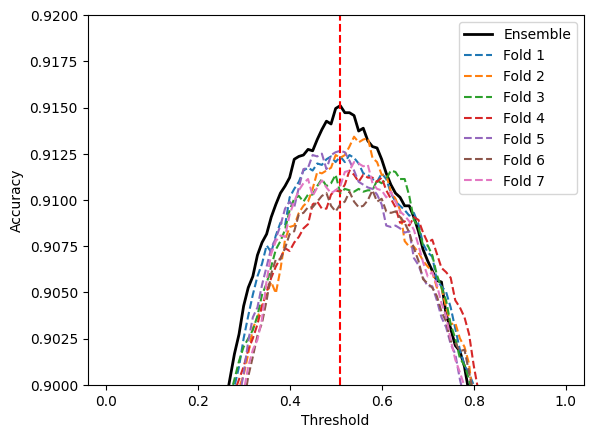

In [42]:
plt.plot(ths, accs, color='black', lw=2, label='Ensemble')
idx_max = np.argmax(accs)
# plot vertical line at max accuracy
plt.axvline(x=ths[idx_max], color='r', linestyle='--')

for fold in range(1, 8):
    plt.plot(ths, accs_model[fold], label=f'Fold {fold}', ls='--')


plt.legend()

plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.ylim(0.9, 0.92)

(0.07, 0.1)

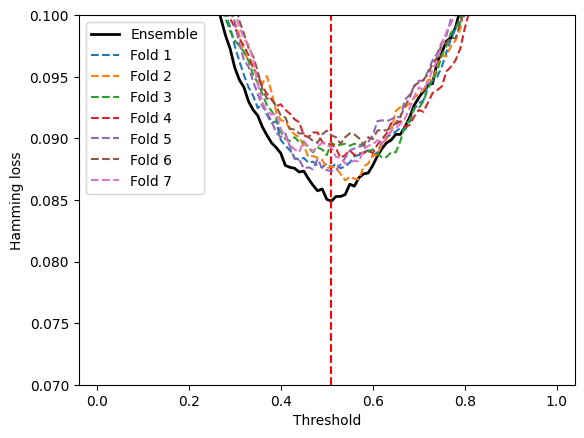

In [41]:
plt.plot(ths, hamming_losses, color='black', lw=2, label='Ensemble')
idx_min = np.argmin(hamming_losses)
# plot vertical line at max accuracy
plt.axvline(x=ths[idx_min], color='r', linestyle='--')

for fold in range(1, 8):
    plt.plot(ths, hamming_losses_model[fold], label=f'Fold {fold}', ls='--')


plt.legend()

plt.ylabel('Hamming loss')
plt.xlabel('Threshold')
plt.ylim(0.07, 0.1)


(0.58, 0.65)

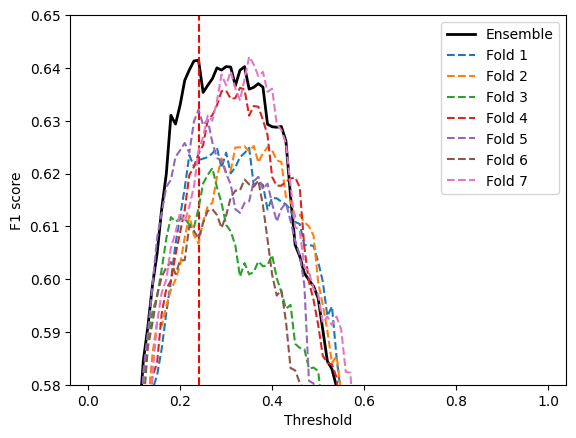

In [40]:
plt.plot(ths, f1_scores, color='black', lw=2, label='Ensemble')
idx_max = np.argmax(f1_scores)
# plot vertical line at max accuracy
plt.axvline(x=ths[idx_max], color='r', linestyle='--')

for fold in range(1, 8):
    plt.plot(ths, f1_scores_model[fold], label=f'Fold {fold}', ls='--')


plt.legend()

plt.ylabel('F1 score')
plt.xlabel('Threshold')
plt.ylim(0.58, 0.65)